### Given a following karate graph  

### Assigment 1. Implementing the Node2Vec model to learn the representations for each node and visualizing the node embeddings via TSNE

In [1]:
import networkx as nx
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

In [2]:
# Loading Karate Graph
dataset = KarateClub()[0]

karate_graph: nx.Graph = to_networkx(dataset)

for node in karate_graph.nodes():
    karate_graph.nodes[node]["class"] = dataset.y.tolist()[node]

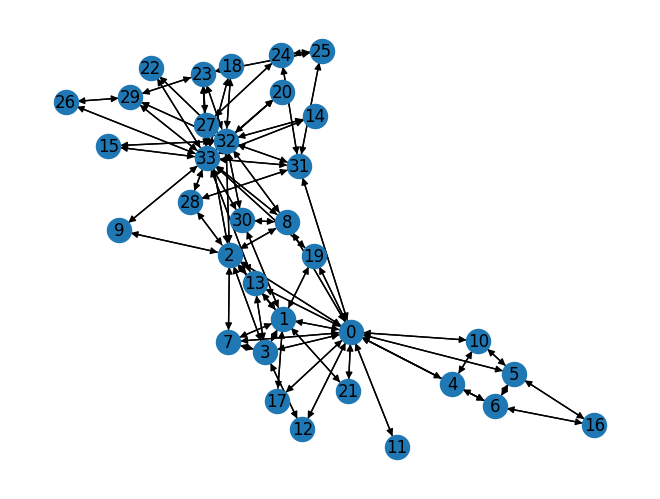

In [3]:
nx.draw(karate_graph, with_labels=True)

In [21]:
import random
def node2vec_walk(G, start_node, num_steps, p, q):
    # Initialize the walk with the start node
    walk = [start_node]

    # Perform the walk for the specified number of steps
    for _ in range(num_steps - 1):
        # Get the current node (last node in the walk)
        current_node = walk[-1]
        # Get the neighbors of the current node
        neighbors = list(G.neighbors(current_node))

        if len(neighbors) > 0:
            # Check if the walk has just started
            if len(walk) == 1:
                next_node = random.choice(neighbors)
            else:
                # Otherwise, choose the next node based on the weighted choice
                next_node = node2vec_weighted_choice(G, current_node, walk[-2], p, q)

            # Append the chosen node to the walk
            walk.append(next_node)
        else:
            # If there are no neighbors, break the loop
            break
    # Return the completed walk
    return walk

def node2vec_weighted_choice(G, current_node, previous_node, p, q):
    # Get the neighbors of the current node
    neighbors = list(G.neighbors(current_node))
    unnormalized_weights = []

    # Calculate unnormalized weights for each neighbor
    for neighbor in neighbors:
        if neighbor == previous_node:
            # If the neighbor is the previous node, apply the return parameter p
            unnormalized_weights.append(1.0 / p)
        elif G.has_edge(current_node, neighbor):
            # If the neighbor is connected to the current node, weight is 1
            unnormalized_weights.append(1.0)
        else:
            # Otherwise, apply the in-out parameter q
            unnormalized_weights.append(1.0 / q)

    # Normalize the weights
    norm_weights = [weight / sum(unnormalized_weights) for weight in unnormalized_weights]
    # Choose the next node based on the normalized weights
    return random.choices(neighbors, weights=norm_weights)[0]

In [10]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from gensim.models import Word2Vec


# Generate a list of 100 random walks on the karate_graph
# Keep the nodes as integers while performing random walks
dataset2 = [
    [str(node) for node in node2vec_walk(  # Convert nodes to string just for Word2Vec
        karate_graph,
        start_node=random.choice(list(karate_graph.nodes())),  # Use integer nodes
        num_steps=10,
        p=0.8,
        q=0.2
    )]
    for _ in range(100)
]

# Train the Word2Vec model using the random walks generated
node2vec_model = Word2Vec(
    sentences=dataset2,
    vector_size=200,
    window=5,
    min_count=1,
    sg=1,
    epochs=100
)

# Get the node embeddings learned by the Word2Vec model
# Convert node to string while accessing the embeddings
node_embeddings = np.array([node2vec_model.wv[str(node)] for node in karate_graph.nodes()])

In [11]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from gensim.models import Word2Vec


# Generate a list of 100 random walks on the karate_graph
# Keep the nodes as integers while performing random walks
dataset2 = [
    [str(node) for node in node2vec_walk(  # Convert nodes to string just for Word2Vec
        karate_graph,
        start_node=random.choice(list(karate_graph.nodes())),  # Use integer nodes
        num_steps=10,
        p=0.8,
        q=0.2
    )]
    for _ in range(100)
]

# Train the Word2Vec model using the random walks generated
node2vec_model = Word2Vec(
    sentences=dataset2,
    vector_size=200,
    window=5,
    min_count=1,
    sg=1,
    epochs=100
)

# Get the node embeddings learned by the Word2Vec model
# Convert node to string while accessing the embeddings
node_embeddings = np.array([node2vec_model.wv[str(node)] for node in karate_graph.nodes()])

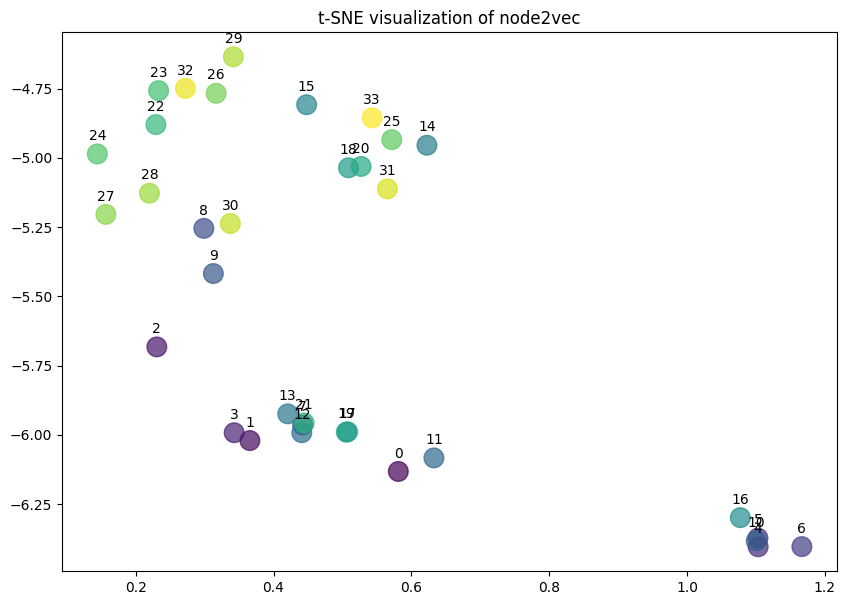

In [12]:
# Reduce dimensions using t-SNE to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualization
plt.figure(figsize=(10, 7))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], s=200, c=list(karate_graph.nodes()), cmap='viridis', alpha=0.7)

# Annotate nodes with their labels
for i, node in enumerate(karate_graph.nodes()):
    plt.annotate(str(node), (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title("t-SNE visualization of node2vec")
plt.show()

### Assigment 2. Implementing the LINE model to learn the representations for each node and visualizing the node embeddings via TSNE

Epoch 1/5, Loss: 4.1591
Epoch 2/5, Loss: 4.1229
Epoch 3/5, Loss: 4.1059
Epoch 4/5, Loss: 4.0495
Epoch 5/5, Loss: 4.0159


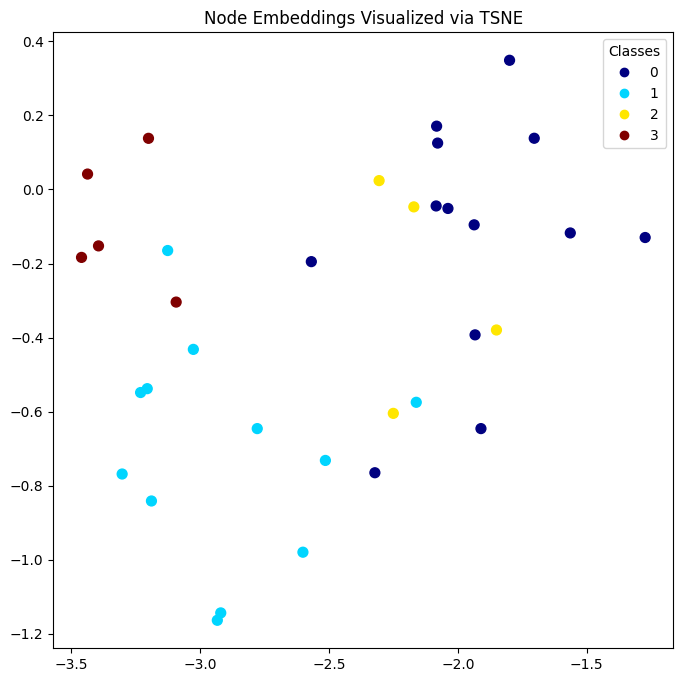

In [23]:
# Vose Alias Method for negative sampling
import torch.nn as nn
import torch
import collections
from decimal import Decimal
import torch.nn.functional as F

class VoseAlias:
    def __init__(self, dist):
        self.dist = dist
        self.alias_initialisation()

    def alias_initialisation(self):
        n = len(self.dist)
        self.table_prob = {}
        self.table_alias = {}
        scaled_prob = {}
        small = []
        large = []

        for o, p in self.dist.items():
            scaled_prob[o] = Decimal(p) * n

            if scaled_prob[o] < 1:
                small.append(o)
            else:
                large.append(o)

        while small and large:
            s = small.pop()
            l = large.pop()

            self.table_prob[s] = scaled_prob[s]
            self.table_alias[s] = l

            scaled_prob[l] = (scaled_prob[l] + scaled_prob[s]) - Decimal(1)

            if scaled_prob[l] < 1:
                small.append(l)
            else:
                large.append(l)

        while large:
            self.table_prob[large.pop()] = Decimal(1)

        while small:
            self.table_prob[small.pop()] = Decimal(1)

        self.listprobs = list(self.table_prob)

    def alias_generation(self):
        col = random.choice(self.listprobs)
        if self.table_prob[col] >= random.uniform(0, 1):
            return col
        else:
            return self.table_alias[col]

    def sample_n(self, size):
        for i in range(size):
            yield self.alias_generation()

# Define the LINE Model
class LINE(nn.Module):
    def __init__(self, size, embed_dim=128, order=1):
        super(LINE, self).__init__()

        assert order in [1, 2], "Order should either be int(1) or int(2)"

        self.embed_dim = embed_dim
        self.order = order
        self.nodes_embeddings = nn.Embedding(size, embed_dim)

        if order == 2:
            self.contextnodes_embeddings = nn.Embedding(size, embed_dim)
            self.contextnodes_embeddings.weight.data = self.contextnodes_embeddings.weight.data.uniform_(
                -.5, .5) / embed_dim

        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(
            -.5, .5) / embed_dim

    def forward(self, v_i, v_j, negsamples, device):
        v_i = self.nodes_embeddings(v_i).to(device)

        if self.order == 2:
            v_j = self.contextnodes_embeddings(v_j).to(device)
            negativenodes = -self.contextnodes_embeddings(negsamples).to(device)
        else:
            v_j = self.nodes_embeddings(v_j).to(device)
            negativenodes = -self.nodes_embeddings(negsamples).to(device)

        mulpositivebatch = torch.mul(v_i, v_j)
        positivebatch = F.logsigmoid(torch.sum(mulpositivebatch, dim=1))

        mulnegativebatch = torch.mul(v_i.view(len(v_i), 1, self.embed_dim), negativenodes)
        negativebatch = torch.sum(F.logsigmoid(torch.sum(mulnegativebatch, dim=2)), dim=1)
        loss = positivebatch + negativebatch
        return -torch.mean(loss)

# Prepare the graph and data
def makeDist(graph: nx.Graph, power=0.75):
    edgedistdict = collections.defaultdict(int)
    nodedistdict = collections.defaultdict(int)
    weightsdict = collections.defaultdict(int)
    nodedegrees = collections.defaultdict(int)

    weightsum = 0
    negprobsum = 0

    for edge in graph.edges(data=True):
        node1, node2, weight = edge[0], edge[1], edge[2].get("weight", 1)
        edgedistdict[tuple([node1, node2])] = weight
        nodedistdict[node1] += weight
        weightsdict[tuple([node1, node2])] = weight
        nodedegrees[node1] += weight
        weightsum += weight
        negprobsum += np.power(weight, power)

    for node, outdegree in nodedistdict.items():
        nodedistdict[node] = np.power(outdegree, power) / negprobsum

    for edge, weight in edgedistdict.items():
        edgedistdict[edge] = weight / weightsum

    return edgedistdict, nodedistdict, weightsdict, nodedegrees

# Negative sampling batch generation
def negSampleBatch(sourcenode, targetnode, negsamplesize, nodesaliassampler):
    negsamples = []
    while len(negsamples) < negsamplesize:
        samplednode = nodesaliassampler.alias_generation()
        if samplednode != sourcenode and samplednode != targetnode:
            negsamples.append(samplednode)
    return torch.tensor(negsamples, dtype=torch.long)

# Training function
def train_line(karate_graph, embed_dim=128, epochs=5, neg_samples=5, order=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LINE(size=len(karate_graph.nodes), embed_dim=embed_dim, order=order).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    edgedistdict, nodedistdict, weightsdict, nodedegrees = makeDist(karate_graph)
    nodesaliassampler = VoseAlias(nodedistdict)

    edges = list(karate_graph.edges())
    node_size = len(karate_graph.nodes)

    for epoch in range(epochs):
        total_loss = 0
        for v_i, v_j in edges:
            v_i = torch.tensor([v_i], dtype=torch.long).to(device)
            v_j = torch.tensor([v_j], dtype=torch.long).to(device)
            neg_samples_batch = negSampleBatch(v_i.item(), v_j.item(), neg_samples, nodesaliassampler).to(device)

            optimizer.zero_grad()
            loss = model(v_i, v_j, neg_samples_batch, device)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(edges):.4f}")

    return model

# TSNE Visualization
def visualize_embeddings(model, karate_graph):
    embeddings = model.nodes_embeddings.weight.cpu().detach().numpy()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    labels = [karate_graph.nodes[node]["class"] for node in karate_graph.nodes]

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', s=50)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("Node Embeddings Visualized via TSNE")
    plt.show()

# Load the Karate Graph
dataset = KarateClub()[0]
karate_graph: nx.Graph = to_networkx(dataset)

# Add class attribute to nodes
for node in karate_graph.nodes():
    karate_graph.nodes[node]["class"] = int(dataset.y[node])

# Train the model and visualize
model = train_line(karate_graph)
visualize_embeddings(model, karate_graph)
